In [1]:
import math
import torch
import torch.nn as nn

from fairseq.models.bart import BARTModel
from utils import read_lines

from transformers import BartTokenizer

In [2]:
xsum_bart = BARTModel.from_pretrained('/home/ml/users/cadencao/Downloads/BART_models/bart.large.xsum',
                                           checkpoint_file='model.pt',
                                           data_name_or_path='/home/ml/users/cadencao/Downloads/BART_models/bart.large.xsum')

In [3]:
clean_bart = BARTModel.from_pretrained('/home/ml/users/cadencao/Downloads/BART_models/checkpoints_xsum_clean',
                                       checkpoint_file='checkpoint_best.pt',
                                       data_name_or_path='/home/ml/users/cadencao/XSum/fairseq_files/xsum-bin') 

#### Read XSum

In [4]:
document_path = '/home/ml/users/cadencao/XSum/fairseq_files/test.source'
target_path = '/home/ml/users/cadencao/XSum/fairseq_files/test.target'
xsum_source = read_lines(document_path)
xsum_target = read_lines(target_path)
print(len(xsum_source))
assert len(xsum_source) == len(xsum_target)

11301


#### Generate Summary

In [5]:
from fairseq.data.data_utils import collate_tokens

In [6]:
class ConditionalSequenceGenerator:
    """Conditional sequence generator for calculating prior and posterior probability."""
    def __init__(self, bart):
        self.bart = bart
        self.tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")
        
        self.encode_func = bart.encode
        self.decode_func = bart.decode
        self.max_positions = bart.max_positions
        self.encode_line = bart.task.source_dictionary.encode_line
        
        self._initialize()
    
    def _initialize(self):
        """Set BART model to evaluation mode."""
        self.bart.cuda()
        self.bart.eval()
        self.bart.half()
        
    def tokenize(self, input_str, append_bos=False, append_eos=True, left_pad=True):
        """BPE-encode a sentence (or multiple sentences).

        Args:
            input_str (str or List[str]): input sentence to be tokenized.
            append_bos (bool): self-explained.
            append_eos (bool): self-explained.

        Return:
            input_ids (torch.Tensor): [batch_size, length]
            src_lengths (torch.Tensor): [batch_size]
        """
        if type(input_str) == type(''):
            input_str = [input_str]

        input_ids = []
        for ins in input_str:
            tokens = self.bart.bpe.encode(ins)  # <mask>: 1279 27932 29
            calibration = sum([append_bos, append_eos])
            if len(tokens.split(" ")) > min(self.max_positions) - calibration:
                tokens = " ".join(tokens.split(" ")[: min(self.max_positions) - calibration])

            tokens = "<s> " + tokens if append_bos else tokens
            tokens = tokens + " </s>" if append_eos else tokens
            ids = self.encode_line(tokens, append_eos=False).long()
            input_ids.append(ids)

        input_ids = collate_tokens(input_ids, pad_idx=1, left_pad=left_pad).cuda()
        input_lengths = torch.sum(input_ids != 1, dim=1).cuda()

        return input_ids, input_lengths
    
    def tokenize_with_mask(self, input_str):
        """Tokenize sentence with a special <mask> token in it.

        Args:
            input_str (str or List[str]): input sentence to be tokenized.

        Return:
            input_ids (torch.Tensor): [batch_size, length]
            src_lengths (torch.Tensor): [batch_size]
        """
        input_ids = self.tokenizer(input_str, return_tensors='pt', padding=True)['input_ids'].cuda()
        input_lengths = torch.sum(input_ids != 1, dim=1).cuda()
        return input_ids, input_lengths
    
    def generate(self, src_input, tgt_input=None):
        """Conditional generation.
        
        Args:
            src_input (str or List[str]): input source sentence to be tokenized.
            tgt_input (str or List[str]): input target sentence to be tokenized.
        """
        input_ids, lengths = self.tokenize(src_input, append_bos=False) 
        
        target_ids = None
        if tgt_input is not None:
            assert len(src_input) == len(tgt_input), "source & target length should match."
            target_ids, _ = self.tokenize(tgt_input, append_bos=False, left_pad=False)
        
        with torch.no_grad():
            encoder_output = self.encode_sequence(input_ids, lengths)
            decoder_output = self.decode_sequence(encoder_output, 
                                                  target_ids=target_ids,
                                                  prefix_tokens=[2])
        return decoder_output
    
    def mask_filling(self, src_input, tgt_input=None):
        """
        Filling the mask in sentence(s).
        """
        input_ids, lengths = self.tokenize_with_mask(src_input)
        
        target_ids = None
        if tgt_input is not None:
            assert len(src_input) == len(tgt_input), "source & target length should match."
            target_ids, _ = self.tokenize(tgt_input, left_pad=False)

        with torch.no_grad():
            encoder_output = self.encode_sequence(input_ids, lengths)
            decoder_output = self.decode_sequence(encoder_output, 
                                                  target_ids=target_ids,
                                                  prefix_tokens=[2, 0])
        return decoder_output
    
    def encode_sequence(self, input_ids, lengths):
        return self.bart.model.encoder(input_ids, src_lengths=lengths)
        
    def decode_sequence(
        self,
        encoder_out,
        target_ids=None,
        min_decode_step=3,
        max_decode_step=100,
        pad_id=1,
        eos_id=2,
        prefix_tokens=[2, 0],
    ):
        batch_size = encoder_out['encoder_padding_mask'][0].shape[0]
        init_input = torch.tensor([prefix_tokens] * batch_size, dtype=torch.long).cuda()
        token_probs, tokens = None, [[] for i in range(batch_size)]
        end_mask = torch.tensor([False] * batch_size).cuda()

        softmax = nn.Softmax(dim=1)
        for step in range(max_decode_step):
            decoder_outputs = self.bart.model.decoder(init_input, encoder_out, features_only=False)
            logits = decoder_outputs[0][:, -1, :]  # logits: [batch_size, vocab]
            attn = decoder_outputs[1]['attn'][0]  # [batch_size, prev_token_len, src_token_len]

            if step + 1 < min_decode_step:
                logits[:, eos_id] = -math.inf  # mask <EOS> token when within minimal step
            logits[:, pad_id], logits[:, 0] = -math.inf, -math.inf  # never select <PAD> & <BOS> token
            probs = softmax(logits)  # probs: [batch_size, vocab]

            # select tokens
            if target_ids is not None:
                selected_token = target_ids[:, step]
            else:
                value, indices = torch.topk(probs, 5, dim=1)
                selected_token = indices[:, 0]

            selected_token = selected_token.masked_fill(end_mask, pad_id)
            init_input = torch.cat([init_input, selected_token.unsqueeze(1)], dim=-1)
            
            probs = torch.gather(probs, 1, selected_token.unsqueeze(1)).detach()
            probs = probs.masked_fill(end_mask.unsqueeze(1), 1.0)
            
            # str & probability
            token_probs = probs if token_probs is None else torch.cat([token_probs, probs], dim=-1)
            for t, s in zip(tokens, selected_token):
                t.append(self.decode_func(s.unsqueeze(0)) if s.item() != pad_id else '<pad>')
            
            # stop generation when all finished
            end_mask = torch.logical_or(end_mask, selected_token == eos_id) 
            if end_mask.sum().item() == batch_size:
                break

        return init_input, tokens, token_probs

In [7]:
def get_probability(position, tokens, probs, entity):
    """Calculate the probability of a span.

    Args:
        position: (start, end)
        tokens: ['The', ' Archbishop', ' of', ...]
        probs: [0.50, 0.49, 0.88, ...]
        entity: Rodgers
    """
    assert len(tokens) == len(probs), "Tokens and token probabilities does not match."
    
    end_pointer, end_pos = 0, []
    for t in tokens:
        end_pointer += len(t)
        end_pos.append(end_pointer)
    
    assert position[1] in end_pos, "- {}\n- {}\n- {}\n- {}\n- {}\n".format(position, tokens, probs, entity, end_pos)
    last_index = end_pos.index(position[1])
    indexes = [last_index]
    total_length = len(tokens[last_index])
    
    while total_length < (position[1] - position[0]):
        last_index -= 1
        assert last_index >= 0
        indexes.append(last_index)
        total_length += len(tokens[last_index])
    
    indexes.reverse()
    
    generated = ''.join([tokens[i] for i in indexes])
    assert entity in generated, 'entity: {}; span: {}'.format(entity, generated)
    
    prob = 1.0
    for i in indexes:
        prob *= probs[i]
    return prob

In [8]:
def get_cmlm_probability(generator, src_input, tgt_input, position, entity):
    outputs = generator.generate(src_input, tgt_input=tgt_input)
    init_input, tokens, token_probs = outputs
    
    probs = []
    for p, tok, tokp, e in zip(position, tokens, token_probs, entity):
        probs.append(get_probability(p, tok, tokp, e).item())
    
    return probs

In [9]:
def get_prior_probability(generator, src_input, tgt_input, position, entity):
    assert len(src_input) == len(tgt_input), "source & target length should match."
    decoder_output = generator.mask_filling(src_input, tgt_input)
    init_input, tokens, token_probs = decoder_output
    
    probs = []
    for p, tok, tokp, e in zip(position, tokens, token_probs, entity):
        probs.append(get_probability(p, tok, tokp, e).item())
    return probs

#### Test One Example

In [10]:
import spacy

nlp = spacy.load('en_core_web_sm')

In [11]:
INDEX = 9444

source = xsum_source[INDEX]
target = "Twin-to-twin transfusion syndrome (TTTS) is being tracked by a hospital in Cardiff in a bid to save the lives of babies born with the condition."

In [12]:
ent_parts = nlp(target).to_json()['ents']
for e in ent_parts:
    print('{} - {}'.format(e, target[e['start']: e['end']]))

{'start': 35, 'end': 39, 'label': 'ORG'} - TTTS
{'start': 75, 'end': 82, 'label': 'ORG'} - Cardiff


In [13]:
prior_model = ConditionalSequenceGenerator(clean_bart)

In [14]:
outputs = prior_model.generate([source], tgt_input=[target])
print(outputs)

(tensor([[    2, 23638,   179,    12,   560,    12, 17137,   179, 30387, 15727,
         14115,    36, 14543,  2685,    43,    16,   145, 12962,    30,    10,
          1098,    11, 12426,    11,    10,  2311,     7,  1871,     5,  1074,
             9,  7272,  2421,    19,     5,  1881,     4,     2]],
       device='cuda:0'), [['Tw', 'in', '-', 'to', '-', 'tw', 'in', ' transf', 'usion', ' syndrome', ' (', 'TT', 'TS', ')', ' is', ' being', ' tracked', ' by', ' a', ' hospital', ' in', ' Cardiff', ' in', ' a', ' bid', ' to', ' save', ' the', ' lives', ' of', ' babies', ' born', ' with', ' the', ' condition', '.', '']], tensor([[8.0032e-03, 7.8613e-01, 5.2002e-01, 9.0283e-01, 9.5117e-01, 8.7354e-01,
         8.8770e-01, 9.2432e-01, 7.1045e-01, 8.7158e-01, 1.1194e-01, 7.5195e-01,
         8.6816e-01, 9.1211e-01, 4.1846e-01, 4.0649e-01, 2.2253e-01, 1.5063e-01,
         5.4102e-01, 2.0154e-01, 1.9019e-01, 5.1498e-04, 2.7771e-02, 5.1367e-01,
         8.1836e-01, 8.8525e-01, 8.7769e-02, 3.300

In [15]:
print(get_probability((35, 39), outputs[1][0], outputs[2][0], 'TTTS'))
print(get_probability((75, 82), outputs[1][0], outputs[2][0], 'Cardiff'))

tensor(0.6528, device='cuda:0', dtype=torch.float16)
tensor(0.0005, device='cuda:0', dtype=torch.float16)


In [16]:
generator = ConditionalSequenceGenerator(xsum_bart)

In [17]:
outputs = generator.generate([source], tgt_input=[target])
print(outputs)

(tensor([[    2, 23638,   179,    12,   560,    12, 17137,   179, 30387, 15727,
         14115,    36, 14543,  2685,    43,    16,   145, 12962,    30,    10,
          1098,    11, 12426,    11,    10,  2311,     7,  1871,     5,  1074,
             9,  7272,  2421,    19,     5,  1881,     4,     2]],
       device='cuda:0'), [['Tw', 'in', '-', 'to', '-', 'tw', 'in', ' transf', 'usion', ' syndrome', ' (', 'TT', 'TS', ')', ' is', ' being', ' tracked', ' by', ' a', ' hospital', ' in', ' Cardiff', ' in', ' a', ' bid', ' to', ' save', ' the', ' lives', ' of', ' babies', ' born', ' with', ' the', ' condition', '.', '']], tensor([[0.0229, 0.8320, 0.3770, 0.9438, 0.9248, 0.7979, 0.9243, 0.9067, 0.6470,
         0.8745, 0.0132, 0.3142, 0.8828, 0.9058, 0.3232, 0.3018, 0.0773, 0.2152,
         0.5469, 0.1202, 0.8262, 0.2532, 0.0859, 0.5059, 0.8950, 0.8779, 0.0726,
         0.2245, 0.8774, 0.8901, 0.3467, 0.0225, 0.8276, 0.7759, 0.8584, 0.8960,
         0.9033]], device='cuda:0', dtype=torch.fl

In [18]:
print(get_probability((35, 39), outputs[1][0], outputs[2][0], 'TTTS'))
print(get_probability((75, 82), outputs[1][0], outputs[2][0], 'Cardiff'))

tensor(0.2773, device='cuda:0', dtype=torch.float16)
tensor(0.2532, device='cuda:0', dtype=torch.float16)


#### Read Annotated Data

In [19]:
import json

from tqdm import tqdm

In [20]:
data = json.load(open('annotated.json', 'r'))
print(len(data))

107


In [21]:
data[55]

{'id': 5747,
 'pred': 'Six teenagers have died from carbon monoxide poisoning after a party at a remote hut in northern Germany, police say.',
 'ents': [{'start': 0, 'end': 3, 'label': 0, 'type': 'CARDINAL', 'ent': 'Six'},
  {'start': 97, 'end': 104, 'label': 0, 'type': 'GPE', 'ent': 'Germany'}],
 'hallucinations': []}

In [22]:
def prepare_inputs(source, target, ent_parts=None):
    if ent_parts is None:
        ent_parts = nlp(target).to_json()['ents']
    
    entities, positions = [], []
    inputs, targets = [], []

    for e in ent_parts:
        positions.append((e['start'], e['end']))
        entities.append(target[e['start']: e['end']])
        inputs.append(source)
        targets.append(target)

    return inputs, targets, entities, positions

In [23]:
prior_model = ConditionalSequenceGenerator(clean_bart)
posterior_model = ConditionalSequenceGenerator(xsum_bart)

for INDEX in tqdm(range(len(data))):
    source = xsum_source[data[INDEX]['id']]
    target = data[INDEX]['pred']
    
    inputs, targets, entities, positions = prepare_inputs(source, target, data[INDEX]['ents'])
    prior_probs = get_cmlm_probability(prior_model, inputs, targets, positions, entities)
    posterior_probs = get_cmlm_probability(posterior_model, inputs, targets, positions, entities)
    
    assert len(prior_probs) == len(posterior_probs) == len(data[INDEX]['ents']), "{};\n {};\n {}".format(prior_probs, posterior_probs, data[INDEX]['ents'])
    for i in range(len(prior_probs)):
        data[INDEX]['ents'][i]['prior'] = prior_probs[i]
        data[INDEX]['ents'][i]['posterior'] = posterior_probs[i]

100%|██████████| 107/107 [05:51<00:00,  3.28s/it]


In [24]:
# import json

In [25]:
# with open('prior_posterior.json', 'w') as fout:
#     json.dump(prior_posterior , fout)

#### Draw Diagram

In [26]:
# prior_posterior = json.load(open('prior_posterior.json', 'r'))
# print(len(prior_posterior))

In [27]:
%matplotlib inline

import matplotlib.pyplot as plt

In [28]:
prior_posterior = []
for d in data:
    for e in d['ents']:
        e['id'] = d['id']
        prior_posterior.append(e)

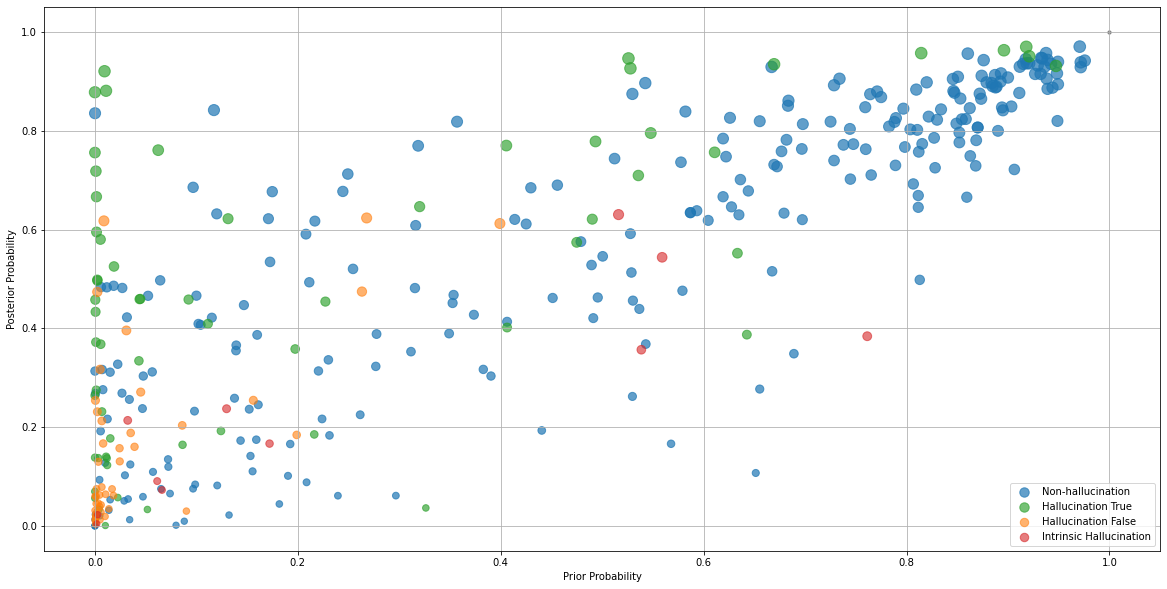

In [29]:
fig, ax = plt.subplots(figsize=(20.0, 10.0))
colors = ['tab:blue', 'tab:orange', 'tab:green']

no_hallucinated = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 0]
hallucinated_true = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 1]
hallucinated_false = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 2]
hallucinated_intrinsic = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 3]

ax.scatter([i[0] for i in no_hallucinated], 
           [i[1] for i in no_hallucinated], c='tab:blue', s=[i[1]*100 + 40 for i in no_hallucinated], label='Non-hallucination', alpha=0.7)

ax.scatter([i[0] for i in hallucinated_true], 
           [i[1] for i in hallucinated_true], c='tab:green', s=[i[1]*100 + 40 for i in hallucinated_true], label='Hallucination True', alpha=0.65)

ax.scatter([i[0] for i in hallucinated_false], 
           [i[1] for i in hallucinated_false], c='tab:orange', s=[i[1]*100 + 40 for i in hallucinated_false], label='Hallucination False', alpha=0.6)

ax.scatter([i[0] for i in hallucinated_intrinsic], 
           [i[1] for i in hallucinated_intrinsic], c='tab:red', s=[i[1]*100 + 40 for i in hallucinated_intrinsic], label='Intrinsic Hallucination', alpha=0.6)

ax.scatter([1.0], [1.0], c='tab:gray', s=10)

ax.set_xlabel('Prior Probability')
ax.set_ylabel('Posterior Probability')
ax.legend()
ax.grid(True)

plt.savefig('foo.png')
plt.show()

In [30]:
for p in prior_posterior:
    if p['prior'] > 0.9:
        print(p)

{'start': 70, 'end': 75, 'label': 0, 'type': 'ORDINAL', 'ent': 'first', 'prior': 0.9716796875, 'posterior': 0.9287109375, 'id': 7079}
{'start': 74, 'end': 79, 'label': 1, 'type': 'PERSON', 'ent': 'David', 'prior': 0.9208984375, 'posterior': 0.95068359375, 'id': 1513}
{'start': 66, 'end': 73, 'label': 0, 'type': 'GPE', 'ent': 'England', 'prior': 0.9482421875, 'posterior': 0.916015625, 'id': 560}
{'start': 68, 'end': 71, 'label': 0, 'type': 'DATE', 'ent': 'May', 'prior': 0.93896484375, 'posterior': 0.943359375, 'id': 10066}
{'start': 7, 'end': 12, 'label': 0, 'type': 'PERSON', 'ent': 'David', 'prior': 0.93798828125, 'posterior': 0.90576171875, 'id': 1367}
{'start': 13, 'end': 20, 'label': 0, 'type': 'PERSON', 'ent': 'Mullins', 'prior': 0.9033203125, 'posterior': 0.84912109375, 'id': 1367}
{'start': 33, 'end': 37, 'label': 0, 'type': 'PERSON', 'ent': 'Tian', 'prior': 0.970703125, 'posterior': 0.97021484375, 'id': 10524}
{'start': 26, 'end': 35, 'label': 0, 'type': 'PERSON', 'ent': 'Tiller

#### Classification

In [31]:
prior_posterior[0]

{'start': 62,
 'end': 75,
 'label': 2,
 'type': 'CARDINAL',
 'ent': 'more than 100',
 'prior': 0.0023746490478515625,
 'posterior': 0.2314453125,
 'id': 8805}

In [32]:
true_label = []
ent_pred_label = []
prob_pred_label = []

for p in prior_posterior:
    if p['label'] is not None:
        source = xsum_source[p['id']]

        if p['ent'].lower() in source.lower():
            ent_pred_label.append(0)
        else:
            ent_pred_label.append(1)

        if p['label'] == 0 or p['label'] == 1:
            true_label.append(0)
        elif p['label'] == 2 or p['label'] == 3:
            true_label.append(1)
        else:
            raise Exception("ERROR! {}".format(p['label']))

        if p['posterior'] > 0.2:
            prob_pred_label.append(0)
        else:
            prob_pred_label.append(1)

In [33]:
from sklearn.metrics import classification_report

In [34]:
print(classification_report(true_label, ent_pred_label, target_names=['Non-factual', 'Factual']))

              precision    recall  f1-score   support

 Non-factual       0.96      0.69      0.81       314
     Factual       0.33      0.86      0.48        56

    accuracy                           0.72       370
   macro avg       0.65      0.77      0.64       370
weighted avg       0.87      0.72      0.76       370



In [35]:
print(classification_report(true_label, prob_pred_label, target_names=['Non-factual', 'Factual']))

              precision    recall  f1-score   support

 Non-factual       0.93      0.81      0.87       314
     Factual       0.38      0.66      0.48        56

    accuracy                           0.79       370
   macro avg       0.66      0.73      0.67       370
weighted avg       0.85      0.79      0.81       370



#### AUC

In [36]:
import numpy as np

from sklearn.metrics import roc_curve, auc

In [37]:
prior_posterior[0]

{'start': 62,
 'end': 75,
 'label': 2,
 'type': 'CARDINAL',
 'ent': 'more than 100',
 'prior': 0.0023746490478515625,
 'posterior': 0.2314453125,
 'id': 8805}

In [38]:
# non-hallucination vs false hallucination

In [39]:
true_label = []
prior_probabilities, posterior_probabilities = [], []

for p in prior_posterior:
    if p['label'] is not None:

        if p['label'] == 0 or p['label'] == 1:
            true_label.append(1)
        elif p['label'] == 2 or p['label'] == 3:
            true_label.append(0)
        else:
            raise Exception("ERROR! {}".format(p['label']))
        
        prior_probabilities.append(p['prior'])
        posterior_probabilities.append(p['posterior'])

In [40]:
true_label = np.asarray(true_label)
prior_probabilities = np.asarray(prior_probabilities)
posterior_probabilities = np.asarray(posterior_probabilities)

In [41]:
true_label.shape

(370,)

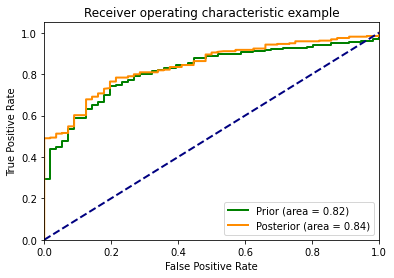

In [42]:
plt.figure()
lw = 2

# prior
fpr, tpr, _ = roc_curve(true_label, prior_probabilities)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='green',
         lw=lw, label='Prior (area = %0.2f)' % roc_auc)

# posterior
fpr, tpr, _ = roc_curve(true_label, posterior_probabilities)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Posterior (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()